## 2. Fasea: Algoritmoak diseinatzen

#### Paula Ontalvilla eta MIkel Zubillaga

Community Detection proiektuaren 1. fasea entregatu duzue, eta feedback-a jaso ere. Klasean hainbat algoritmo ikusi ditugu, batzuk soluzio bakarrean oinarritutakoak, beste batzuk aldiz, populazio bat erabiltzen dutenak. Horiez gain, hibridatzeko teknikak ere ikusi ditugu. Bigarrengo fase honetan, hiru algoritmo diseinatu beharko dituzue. Lehenengoa, algoritmo eraikitzaile bat izango da. Bigarrena, soluzio bakarrean oinarritutako heuristiko bat izan beharko du, eta azkenik, hirugarrena algoritmo poblazional bat izango da. Hiru algoritmoak estokastikoak izan beharko dute, eta horietatik, bik, oinarri probabilistikoa izan beharko dute. Adibidez, Simulated Annealing, Estimation of Distribution Algorithms (EDAk) edota Ant Colony Optimization (ACO) implementatu ditzazkezue. Proiektu honen kasuan, algoritmoen helburua, komunitate kopuru jakin bat emanik, modularitatea maximizatzen duen komunitate banaketa (soluzioa) bilatzen saiatzea da.

Errepasatu gaitegian zehar ikusi ditugun algoritmo guztiak, eta horiek kontuak izanik, libre zarete nahi dituzuen diseinuak sortzeko, baita ere hibridoak! Adi! Egiten duzuen aukeraketa argudiatu egin beharko duzue.

#### Entregablea

Bigarrengo fasea ebaluatu ahal izateko, notebook honetan bertan algoritmoen diseinua eta implementazioa proposatu beharko duzue. Gogoratu algoritmo bat azaltzeko modurik errezena fluxu diagrama eta sasikode bat egitea direla. Adi! Atal bakoitzean hartutako erabakiak eta garatutako metodoak egoki argudiatu beharko dituzue. Azalpenak ere nahi ditut. Diagramak ez dira eurak bakarrik azaltzen, beraz testutik erreferentziatu egin beharko dituzue. Saiatu idazkera zientifiko-tekniko batekin idazten (pentsatu publikatuko duzuen lan bat dela). Ez argudiatzeak edo lana garaiz ez entregatzeak penalizazioa jasoko dute ebaluagarria den proiektuaren zati honetan. eGelan zehazten dira notebook-a igotzeko <b>egun eta orduak</b>.

Momentuz, ez daukazue algoritmoen exekuzio eta konparaketak egin behar. Hirugarren fasean, esperimentazioaren inguruko baldintzak emango dizkizuet, eta, horrez gain, txostenaren idazketa burutu beharko duzue.

# Import-ak, aldagai eta funtzio orokorrak
Lehenik eta behin beharrezkoak diren  import-ak egingo ditugu:

Aurreko faseko 3 funtzio erabiliko ditugu:
* `sortu_grafoa`: Gure G grafoa sortzen du.
* `kalkulatuHasierakoMAT`: modularitatea kalkulatzeko beharrezkoak diren kalkuluak egin eta aldagaietan gordetzen ditu.
* `modularitatea2OPT`: modularitatea kalkulatzen du aurreko funtzioko aldagaiak hartuz. Aurreko fasean esan bezala, funtzio hau erabiltzea erabaki dugu eraginkorrenetako bat delako eta *community* moduluko emaitza berdinak lortzen dituelako. Funtzio hau erabiliko da helburu funtzioa kakulatzeko. Gure problemaren helburua modularitatea maximizatzea da.

In [3]:
from itertools import product
from ipynb.fs.defs.CDP_1_fasea_PAMI import sortu_grafoa 
import community 
import networkx as nx
import numpy as np
import random as rm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import copy
import math
import networkx as nx
import numpy as np
import sqlite3
import pandas as pd
import itertools
import time
from pdb import set_trace
from collections import defaultdict

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211
Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211
Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211


In [4]:
def kalkulatuHasierakoMAT(G, weight='weight'):
    K = [[0 for i in range(len(G))]for j in range(len(G))]
    A = [[0 for i in range(len(G))]for j in range(len(G))]
    i = 0
    m = G.size(weight=weight)
    degree = {}
    for node in G:
        j = 0
        degree[node] = G.degree(node, weight=weight)
        for nbr, eattr in G[node].items():
            K[i][j] = G.degree(node, weight=weight)*G.degree(nbr, weight=weight)
            A[i][j] = eattr[weight]
            if i == j:
                A[i][j] *= 2
            j += 1
        i += 1
    K = np.array(K)/np.array(2*m)
    A = np.array(A)
    AK = (A-K)/np.array(2*m)
    
    return AK,m,degree

def modularitatea2OPT(G, partizioa, degree, m, weight='weight'):
    a = defaultdict(float)
    e = defaultdict(float)
    modularitatea = 0
    
    for node in G: #nodo bakoitzeko
        c = partizioa[node]
        a[c] += degree[node]
        for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            if partizioa[nbr] == c:
                e[c]  += eattr[weight]
        
    for i in set(partizioa.values()):
        modularitatea += (e[i] / (2 * m)) - (a[i] / (2 * m)) ** 2
    
    return modularitatea, a ,e    


Funtzio orokorrak definituko ditugu:

`partizioak_irudikatu(G,k, partizioa)`partizio bat eta partizio kopuru bat jasota, partizio bakoitza kolore desberdin batekin adieraziko du.

`from_dict_to_list(G, partizio)`Grafoa eta *dictionary* moduan adierazitako partizio bat emanda lista bat itzuliko du.

`bistaratu_grafoa(G)`grafoa emanda nodoak eta haien arteko ertzak inprimatzen ditu.

In [5]:
 def partizioak_irudikatu(G, k, partizioa):
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)

    number_of_colors = k
    i, color = 0, []
    while i < number_of_colors:
        color_aux =[rm.choice('0123456789ABCDEF') for j in range(6)]
        if color_aux not in color:
            color.append("#"+''.join(color_aux))
            i += 1
             
    #kolore desberdinak izan behar dira
    assert(len(np.unique(color)) == number_of_colors)

    # Draw a subgraph, reusing the same node positions
    for i in range(k):
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
        nx.draw(G.subgraph(partizioa_elem),node_size = 20, pos=pos, node_color=color[i])

    plt.show()

    plt.axis('off')
    plt.show()

In [6]:
def from_dict_to_list(G, partizioa):
    solution = []
    for autore in G.nodes():
        solution.append(partizioa[autore])
    return solution
        

In [7]:
def bistaratu_grafoa(G):
    #Draw graph
    plt.figure(figsize=(13, 9))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size = 20, node_color='0.75', label=True)
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
    plt.show()

    plt.axis('off')
    plt.show()

Aldagai orokorrak hasieratuko ditugu:  

Gure hasierako `G` grafoan, autore bakoitzeko nodo bat izango dugu, eta bi autoreren artean elkarlana egon bada (artikulu bat batera idatzi badute), orduan dagozkien nodoen artean arku bat egongo da. Baina ez da berdina elkarlan bat egitea, edo 100. Horregatik, arkuek pisu bat izango dute, elkarlan kopurua adieraziko duena.

In [8]:
G_ = sortu_grafoa()

Autore kopurua grafoan: 1843
Elkarlan kopurua grafoan: 3211


# Aurre-prozesaketa

Gure problemak daukan arazo nagusia grafoaren tamaina da 1843 nodo eta 3211 arku ditu, hain zuzen ere. Honek asko zailtzen du soluzio bat aurkitzea. Izan ere, gure kodeketaren bilaketa espazio grafoan ditugun nodo kopuruan menpeko da. Hortaz, bilaketa lokaletan sortuko den ingurunea oso handia da eta konputazio aldetik ezinezkoa. Adibidez, *swap* funtzioa erabiltzen baldin bada $\binom{1843}{2}$ kandidato desberdin sortu beharko lituzke ingurune funtzioak.  

Bestalde, gure grafoari erreparatzen baldin badiogu (1. irudia) ikus daiteke nodo asko ditugula gutxi batzuekin konektatuta edo bakarrik.  Hauek gure helburu funtzioan ez dute eragin handirik izango, hau da, ez dute modularitatea asko aldatuko, hauen arteko elkarlana txikia izango baita beraien arteko ertz kopuru bajuagatik. Nodo hauek, gure probleman erredundantzia sortzen dute.

Beraz, arazo honi aurre egiteko erabaki dugu aurre-prozesaketa bat egitea. Nodo erredundate hauek kenduko ditugu, gure problemaren nodo kopurua eta konputazio maila murriztuz. Orain erdiko nodo horien partizioaren optimizazioan zentratuko gara. Hori ebatzi ostean nodo erredundante horiek edozein partizioetan sartuko ditugu ez baitu gure soluzioa aldatuko.

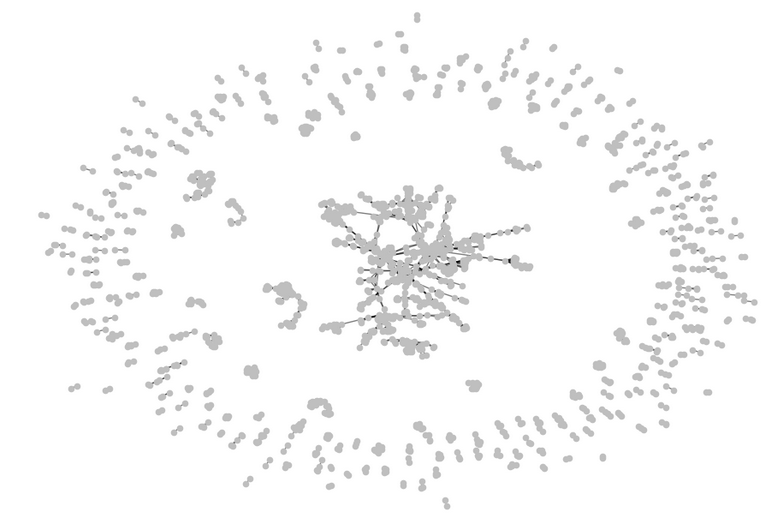
**1. irudia.** Gure problemaren grafoa

## Kodea


In [9]:
def sakonerako_korritzea(G, node, aurkitutakoak):
    aurkitutakoak[node] = True
    kont = 0
    for auz,_ in G[node].items():
        if not aurkitutakoak[auz]:
            aurkitutakoak[auz] = True
            kont += 1 + sakonerako_korritzea(G, auz, aurkitutakoak)
    return kont
        
def aurreprozesaketa(G):
    auzokideak = {}
    for node in G:
        aurkitutakoak = {}
        for node2 in G:
            aurkitutakoak[node2] = False
        auzokideak[node] = sakonerako_korritzea(G, node, aurkitutakoak)
    auzokideak = dict(sorted(auzokideak.items(), key=lambda x: x[1], reverse=True))
    return auzokideak

def grafo_aurreprozesaketa(auzokideak, G):
    # Datuak irakurri
    # Get data
    connect = sqlite3.connect('./nips-papers/database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)

    # Have a look at data
    df.head(10)
    G_ = nx.Graph()
    kanpokoak = {}
    # Transform
    # Autorearen IDa erabili beharrean erabili izena.
    for p, a in df.groupby('paper_id')['name']: 
        for u, v in itertools.combinations(a, 2):
            if u != v and auzokideak[u]>100 and auzokideak[v]>100:#ez badira nodo berdina
                if G_.has_edge(u, v):
                    G_[u][v]['weight'] +=1
                else:
                    G_.add_edge(u, v, weight=1)
            elif u != v:
                if auzokideak[u] <= 100:
                    kanpokoak[u] = G[u]
                if auzokideak[v] <= 100:
                    kanpokoak[v] = G[v]
    # Print graph size
    print('Autore kopurua grafoan:', G_.number_of_nodes())
    print('Elkarlan kopurua grafoan:', G_.number_of_edges())
    
    return G_, kanpokoak

Orain gure sarrerako grafoaren aurre-prozesaketa bat egingo dugu eta hau bistaratuko dugu.

Autore kopurua grafoan: 531
Elkarlan kopurua grafoan: 1124


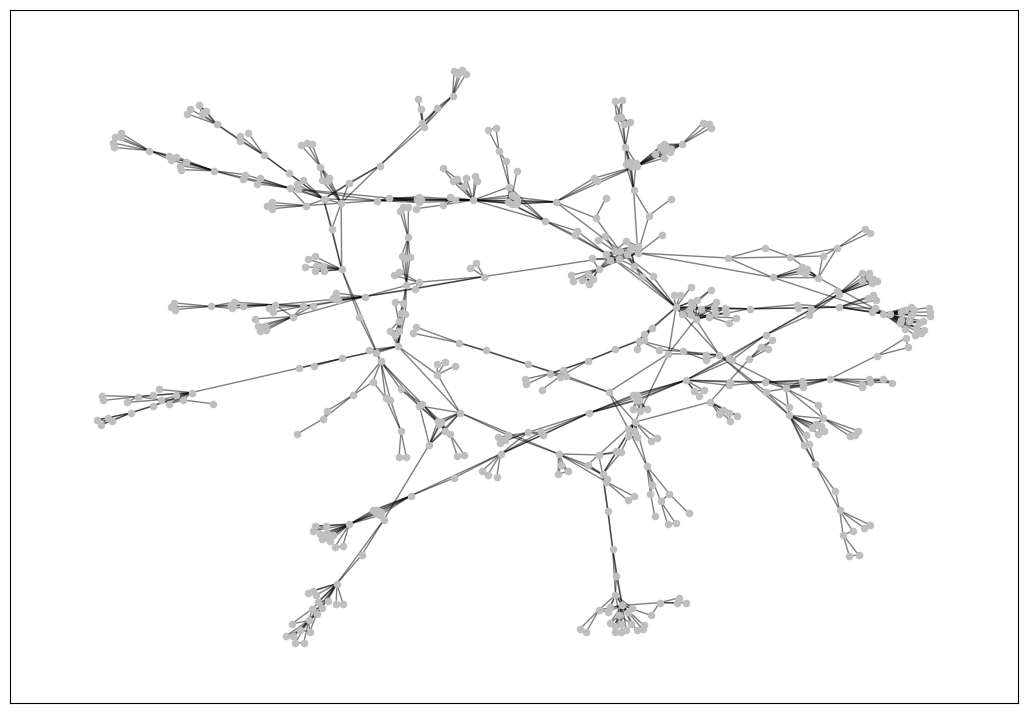

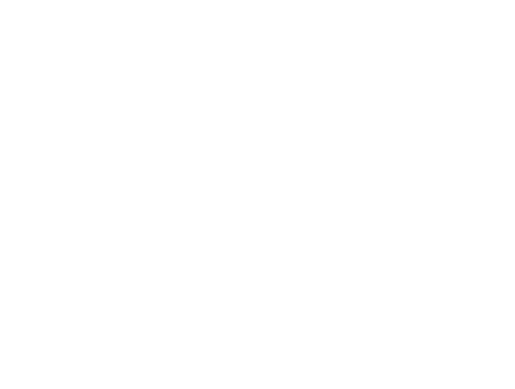

In [10]:
auzokideak = aurreprozesaketa(G_)
G, kanpokoak = grafo_aurreprozesaketa(auzokideak, G_)
bistaratu_grafoa(G)

Orain gure problemak 1843 nodo izatetik 531 nodo izatera pasa da. Aurre-prozesaketa honen bidez nodo kopurua erdia baino gutxiagora murriztu dugu. Goian ikus dezakegu gure grafo berria zein den, gure hasierako grafoko erdiko nodoak dira, hain zuzen ere.   

Hemendik aurrera egingo ditugun kalkulu guztiak grafo horrekin egingo dira.

Jarraian definitzeko geratzen zaizkigun aldagai orokorrak ditugu. Aurre-prozesatutako grafoa `G` izango da eta elkarlan guztien batura adieraziko da `m` aldagaiaren bidez. Bestalde,`degree` eta `AK` aldagaiak modularitatea optimizatzeko aldagaiak dira. Hauek zehazki grafoan dauden nodoen gradua eta  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$ eragiketaren emaitzak gordetzen ditu. Modu honetan informazio hau modularitatea kalkulatzerakoan ez da behin eta berriz kalkulatu behar, `AK` aldagaian egongo baita gordeta.

In [11]:
m = G.size(weight='weight')
AK,m,degree = kalkulatuHasierakoMAT(G)
G['Sewoong Oh']['Devavrat Shah']['weight']

1

In [42]:
def lagindu_autoreak(G, weight = 'weight'):
    autoreak = {}
    pisu_totala = 0
    for node in G: #nodo bakoitzeko
        pisua = 0
        for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            wt = eattr[weight] #n eta nbr arteko pisuak
            pisua += wt
        autoreak[node] = pisua
        pisu_totala += pisua
    #prob
    for a in autoreak:
        autoreak[a] /= pisu_totala
    list_autoreak = [(izena, prob) for izena,prob in autoreak.items()]
    return list_autoreak
        
    
laginketa_autoreak = lagindu_autoreak(G)

def aukeratu(kopurua):
    balioak = copy.deepcopy(laginketa_autoreak)
    aukeratuak = []
    
    for i in range(kopurua):
  
        row = [b[1] for b in balioak]
        aukera = rm.uniform(0, sum(row))
        zenbat = 0
        for j in range(len(balioak)):
            zenbat += balioak[j][1]
            if zenbat >= aukera:
                aukeratuak.append(balioak[j][0])
                balioak.pop(j)
                break
    return aukeratuak
    
def sortzailea(kopurua, G):
    aukeratuak = aukeratu(kopurua)    
    G_ = nx.Graph()
    for node in G:
        if node in aukeratuak:
            G_.add_node(node)#hau kendu puntuak ez egoteko grafoan
            for nbr, eattr in G[node].items():
                if nbr in aukeratuak:
                    G_.add_edge(node, nbr, weight=G[node][nbr]['weight'])
    return G_

Graph with 300 nodes and 538 edges


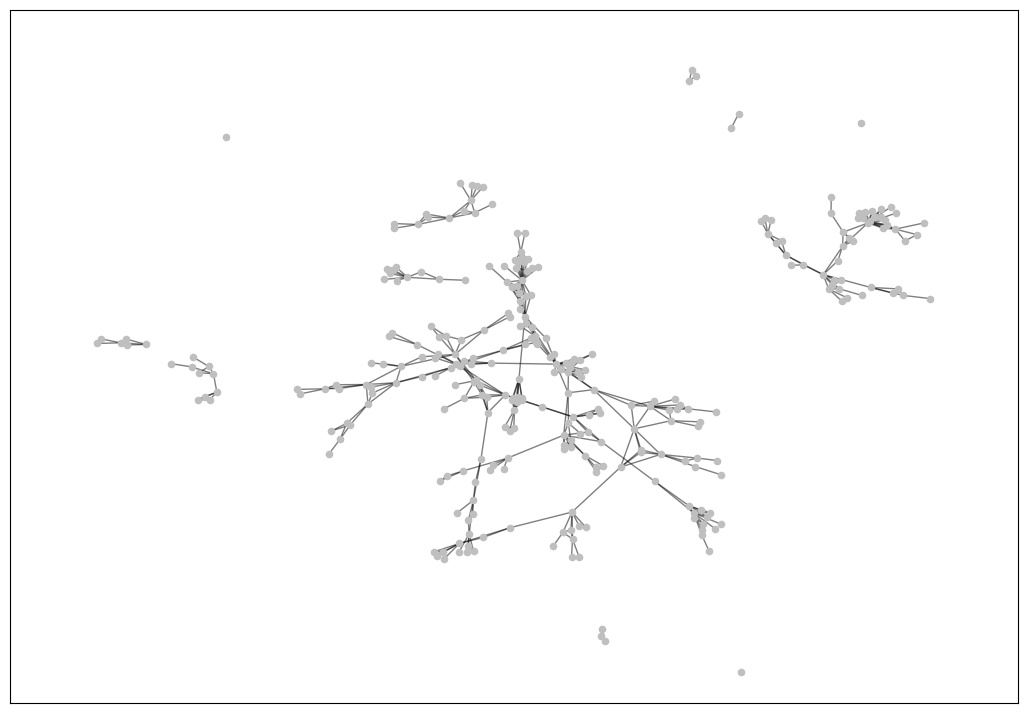

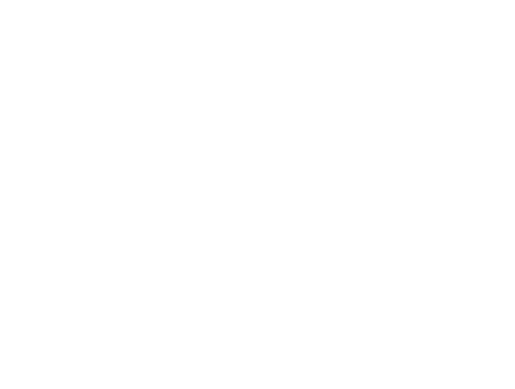

In [44]:
kopurua = 300
grafoa = sortzailea(kopurua, G)
print(grafoa)
bistaratu_grafoa(grafoa)

Funtzio bat sortuko dugu kanpoko nodoak gure soluzioan sartzeko. Esan bezala nodo horiek erredundanteak dira eta ez dute modularitatean eraginik. Horregatik, nodo bakoitza ausaz partizio batean sartuko da.

In [ ]:
def kanpokoak_sartu( partition, k):
    maxim, elem_max = -float('inf'), None
    for elem in kanpokoak:
        i = rm.randint(0,k)
        partition[elem] = i
        
    return  partition

# Random Search

Hasteko, *random search* inplementatuko dugu baseline edo oinarri-lerro moduan erabiltzeko. Horrela, inplementatzen ditugun beste algoritmoekin lortzen ditugun soluzioekin konpara ditzakegu. Badakigu gure algoritmoetan lortzen ditugun soluzioak *random search*-ek itzultzen digunaren berdinak edo hobeak izan behar direla.

In [ ]:
def random_search(G, kop, num_solutions):
    size = len(G)
    maxim = -float('inf')
    best_solution = []
    for i in range(num_solutions):
        k = rm.randint(0,kop)
        sol = [i for i in range(k)] + [rm.randint(0,k) for i in range(size-k)]
        partition = dict(zip(G.nodes, sol))
        fitness,_,_ = modularitatea2OPT(G, partition, degree, m)
        if (fitness > maxim):
            maxim = fitness
            best_solution = sol

    return maxim,best_solution


In [ ]:
k = 5
itera = 200
start = time.time()
fitness, solution = random_search(G,k, itera)
partition = dict(zip(G.nodes, solution))
partition = kanpokoak_sartu(partition, k)
print(time.time()-start)
#modularitatea kalkulatuko dugu
print("Soluzioaren modularitatea: ", str(fitness))

In [ ]:
#partizioak_irudikatu(G_, k, partition)

*Random Search*-ek 200 soluzio desberdinekin probatuz lortzen duen modularitaterik onena 0.043301909438214305 da. Beraz, hemendik aurrera inplementatzen ditugun algoritmoek soluzio hau baino hobea edo berdina den soluzio bat eman behar digute ondo inplementatua baldin badaude.  

Behin hau edukita has gaitezke eskatzen diren hiru algoritmo desberdinak inplementatzen.

# Algoritmo eraikitzailea

Algoritmo eraikitzaileak soluzio huts batetik hasten dira eta iteratiboki, elementuak gehitu ohi dira soluzioan. Soluzioan egoteko irizpide bat maximizatuko duen elementua aukeratzen da. Algoritmoa hau estokastikoa da, ez du beti soluzio berdina bueltatzen ausaz aukeraketa batzuk egiten direlako.

Inplementatutako algoritmoak hurrengoa egiten du:
1. `k` aldagai bat jasotzen du zeinak partizio kopurua adierazten duen. Aurre-prozesaketa egin denez nodo guztiek garrantzia berdina dute; beraz, *k* autore aukeratzen dira ausaz eta *k* autore bakoitzak partizio bat osatuko du.

2. Partizio bakoitzean autore berri bat sartzen da iteratiboki.  Nodo bat hartzen baldin bada ze partizioan jartzearen erabakia ez da tribiala horrek eragin handia izango baitu modularitatean; beraz, kontu handiz egin behar den zerbait da. Lehenik eta behin partizioan sartzen diren nodo (autore) berriak partizioko beste autoreekin konektatuta egon behar dute. Honela, modularitatea maximizatuko da partizioan sartzen ditugun nodoak konektatuta daudelako, hau da, nodo hauek berain artean elkarlan maila bat dutelako. Hortaz, partizio bakoitzean dauden nodo bakoitzaren auzokideak aztertu egiten dira eta sartu egiten da modularitatea gehien maximizatzen duen autorea. Zehazki, hurrengo kalkulua maximizatzen duena:  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$ 

3. Partizio bakoitzean dauden nodoen auzokide guztiak aztertu eta dagokion partizion sartu direnean autore batzuk sartu gabe gelditzen dira. Sartzeke geratzen diren autoreak partizioko nodoekin erlaziorik ez dute izango, hau da, ez daude konektatuta, ez dute elkarlanik. Nahiz eta elkarlanik ez izan nodo hauek ez dira ausaz partizio batean sartuko, nodo bakoitza gradu bat daukalako eta hau baita erabiltzen delako modularitatea kalkulatzean. Hortaz, sartzeke geratzen diren autore bakoitza modularitatea gehien handitzen duen partizioan sartzen da iteratiboki. Zehazki, hurrengo kalkulua maximizatzen duen partizioan:  $\left[A_{vw}-\frac{k_vk_w}{2m}\right]$, $A_{vw} = 0$ izango da ertzik ez dagoelako.

## Sasikodea

**Sarrera:**
* $k$ : egingo diren partizio kopurua
* $G$ : grafo bat nodo bakoitza idazle bat izanik eta ertzak idazleen arteko elkarlana adieraziz

**Irteera:** $C$ : modularitatea maximizatzen duen partizioa

**Hasieraketa:**
> $C = \{ C_{1},...,C_{k}\}$
>
**Algoritmoa:**
> eguneratu = True 
>
> **while** eguneratu:
>>
>> **for** i in range(k)
>>>  v = Q maximizatzen duen nodoa
>>>
>>> **if** v == None:
>>>
>>>> eguneratu = False  
>>>
>>> **else:**
>>>
>>>> $C_{i} ← C_{i} ∪ {v}  $  
>>>>
>>>> $V ← V \backslash \{v \}$
>
> **while** V $\neq \emptyset$:
>>**for** i in range(k):
>>
>>> v = Q maximizatzen duen nodoa
>>>
>> $C_{i} ← C_{i} ∪ {v}  $  
>>
>> $V ← V \backslash \{v \}$
>>
> **return** C


## Kodea

In [ ]:
def aukeratu_onena(G, partizioa_elem, aztertuak, weight):
    maxim, elem_max = -float('inf'), None
    for elem in partizioa_elem:
        kv = G.degree(elem, weight=weight)
        for nbr, eattr in G[elem].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
            if nbr not in aztertuak: #ez baldin bada aztertua izan
                wt = eattr[weight] #n eta nbr arteko pisuak
                kw = G.degree(nbr, weight=weight)
                batu = wt - (kv * kw)/(2*m)
                if batu > maxim:
                    maxim = batu
                    elem_max = nbr
    return elem_max

def partizio_partziala(G, k, partizioa,weight, aztertutakoak):
    eguneratu = True
    while eguneratu: 
        for i in range(k): #partizio bakoitzeko
            partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak
            elem_onena = aukeratu_onena(G, partizioa_elem, aztertutakoak, weight)
            if elem_onena == None:
                eguneratu = False
            else:
                eguneratu = True
                aztertutakoak.append(elem_onena)
                partizioa[elem_onena] = i
    return partizioa, aztertutakoak

def partizio_onenean_sartu(G, k, partizioa, weight, node):
    maxim, partizio_onena, elem_max = -float('inf'), None, None
    for i in range(k): #partizio bakoitzeko
        batu = 0
        partizioa_elem = [k for k,v in partizioa.items() if v==i] #lortu i. partizioko elementuak        
        for elem in partizioa_elem:
            kv = G.degree(elem, weight=weight)
            kw = G.degree(node, weight=weight)
            batu += - (kv * kw)/(2*m) #Avw = 0 izango da ez daudelako konketatuta
        if batu > maxim:
            maxim = batu
            partizio_onena = i
    partizioa[node] = partizio_onena #sartu 
    return partizioa
    
#partizio bakoitzean egongo diren idazleak ausaz aukeratuko dira
def algoritmo_eraikitzailea(G, k, weight= 'weight'):
    hasi_elem =  rm.sample([node for node in G], k) #aukeratu k ausaz #hasieraketa(G,k)
    aztertutakoak =[] 
    partizioa = {}
    kont = 0
    eguneratu = True
    for elem in hasi_elem: #sartu elementu bakoitza partizio batean
        aztertutakoak.append(elem)
        partizioa[elem] = kont
        kont += 1
    #sortutako lehenengo partizioa aukeratutako elementuekin. Partizioetan dauden elementuak konektata daude
    lehenengo_partizioa, aztertutakoak = partizio_partziala(G, k, partizioa, weight, aztertutakoak)
    #partizioen barruko elementuekin konektatu gabeko elementuak gehitu behar ditugu    
    for node in G:
        if node not in aztertutakoak: #ez baldin bada aztertu
            partizioa = partizio_onenean_sartu(G, k, partizioa, weight, node)
            aztertutakoak.append(node)
    
    return partizioa

500 nodo inguru edukita eta partizio kopurua 20-ean ezarriz ematen digun modularitatea hurrengoa izan da:

In [ ]:
k = 5
start = time.time()
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
#modularitatea kalkulatuko dugu
print("Soluzioaren modularitatea aurre-prozesatutako grafoan: ", modularitatea2OPT(G,partizioa, degree, m)[0])
partizioa1 = kanpokoak_sartu(partizioa, k)
print(time.time()-start)
print("Soluzioaren modularitatea problemaren grafoaren gainean: ", modularitatea2OPT(G, partizioa1, degree, m)[0])

Ikus daitekenez lortu dugun modularitatea *Random Search* bidez lortutako baino handiagoa da. Seinale ona da hori. Gainera ikus daiteke aurretik aipatutakoa, aurre-prozesaketaren grafoan ez dauden nodoak erredundanteak dira hauek edozein partizioetan sartu ostean ez dutelako modularitatean eraginik. Bi kasuetan modularitate berdina lortzen da. Jarraian, lortutako soluzioak irudikatuko daude partizio bakoitza kolore batez margotuta dagoelarik. Lehenengo grafoa aurre-prozesatutako grafoa da eta bigarrena sarreran sartutako grafoa.

In [ ]:
#partizioak_irudikatu(G , k , partizioa)

In [ ]:
#partizioak_irudikatu(G_, k , partizioa)

# Soluzio bakarrean oinarritutako heuristikoak: ILS hibidridoa

Soluzio bakarrean oinarritutako heuristiko moduan ILS hibrido bat egitea aukeratu dugu. ILS algoritmoak hasierako ausazko soluzio batetik hasten da, baina gure hibridoak ILS algoritmoa aplikatzen du soluzio estokastiko baten gainean. ILSk uneko optimo lokala hartuko du oinarritzat eta optimo lokal batean trabatuta geratzen denean, uneko soluzioa *perturbatu* egingo du eta bertatik bilatzen jarraituko du. Optimo lokal berri batera heltzen garenean, soluzio hori onartuko dugun erabaki behar da. [1] Hurrengo argazkian, ikus 2.irudia, ILS algoritmoaren ideia azaltzen da.

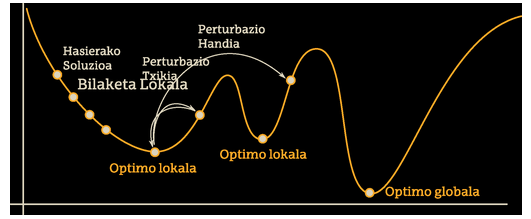
**2.irudia.** ILS algoritmoaren ideia.

Algoritmoa azaltzeko bi prozedura berri zehaztu behar dira: *perturbazioa* eta *onartze irizpidea*.

* **Perturbazioa:** Hasteko, optimo lokal batean trabatuta geratzen denean, hura nola perturbatu pentsatu behar da. Soluzio bateko inguruneko soluzioak antzekoak direnez aldaketa handiak sartu behar dira  optimo lokalatik alde egiteko. 2. irudian ikus daiteke perturbazioaren tamaina garrantzia handia duela. Izan ere, oso handia baldin bada optimo globaletik pasa gaitezke eta beste optimo lokal batean trabatuta gelditu. Aurrerago azaldu egingo da zein perturbazio mota eta gradu erabiliko diren.

* **Onartze iripidea:** Uneko optimo lokala perturbatu ondoren bilaketa lokala aplikatzen da eta erabaki behar da zein perturbatuko den: Lortutako optimo berria edo berriro optimo zaharra. Aurrerago azalduko da problema honetarako erabili den onartze irizpidea.[1]

## ILS-ren sasikodea
**Sarrera:** $G$ :grafo bat nodo bakoitza idazle bat izanik eta ertzak idazleen arteko elkarlana adieraziz

**Irteera:** $s_{best}$: modularitatea maximizatzen duen soluzioa

**Algoritmoa:**
> $ s^*$= Generate initial solution() 
>
> $s_{best} = s^*$  
>
> 1: **repeat**  
>
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^´$ =  perturbation$(s^*)$
>
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^*´$ = local\_search$(s^´)$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^*$ = simmulated\_annealing$(s^*´, s^*)$
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $Q(s^*)$ > Q($s_{best}$) **then**
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{best} = s^* $  
>
> 7: **until** $!stop\_criterion()$

## Hasieraketa
Gure hasierako partizioa hasieratzeko era desberdinak ikusi ditugu. Horietako bat *greedy constructive heuristic* (GCH) Sanchez et al proposatutakoa. Horren sasikodea 3. irudian ikus daiteke. GCH-k, lehenik, V erpin multzotik v nodo bat aukeratzen du ausaz. Ondoren, v nodoa jasotzen duen kluster bat gehitzen zaio eraikuntzarako *s* soluzioari. Jarraitzeko, hurrengo nodoa ausaz aukeratzen da eta GCH-k ebaluatzen du nolako modularitatea dagoen nodoa $C_{i}$ kluster bakoitzean sartzean. Orduan, emaitzarik onena duen modularitea soluzioen egungo modularitatea baino handiagoa bada, nodoa dagokion $C_{i}$  klusterrean sartuko da. Bestela, v nodoa duen multzo berri bat sartzen da s soluzioan. Azkenik, hautatutako nodoa V multzotik kentzen da. Prozesua errepikatzen da V multzoa hutsik egon arte.[2]


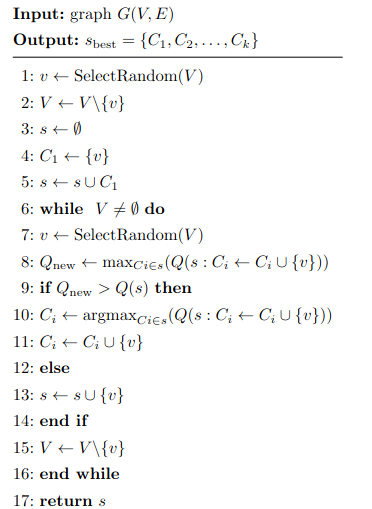
**3. irudia** GCH algoritmoaren sasikodea

### Kodea

In [ ]:
def hasieratu(G):
    nodoak = list(G.nodes())
    node = rm.choice(nodoak)
    i = 1
    nodoak.remove(node)
    partizioa = {}
    for n in nodoak:
        partizioa[n] = 0

    partizioa[node] = i
    Q,_,_ = modularitatea2OPT(G, partizioa, degree, m)
    while nodoak!= []:
        hobetu = False
        node = rm.choice(nodoak)
        for j in range(i):
            partizioa[node] = j
            Q1,_,_ = modularitatea2OPT(G, partizioa, degree, m)
            if Q1 > Q:
                hobetu = True
                break
        if not hobetu:
            i += 1
            partizioa[node] = i
        nodoak.remove(node)
        Q,_,_ = modularitatea2OPT(G, partizioa, degree, m)
    return partizioa

In [ ]:
partizioaILS = hasieratu(G)
#modularitatea kalkulatuko dugu
kILS = len(np.unique(list(partizioaILS.values())))
print("Partizio kopurua: "+ str(kILS))
print("Soluzioaren modularitatea aurre-prozesatutako grafoan: ", modularitatea2OPT(G,partizioaILS, degree, m)[0])
partizioaILS1 = kanpokoak_sartu(partizioaILS, kILS)
print("Soluzioaren modularitatea problemaren grafoaren gainean: ", modularitatea2OPT(G, partizioaILS1, degree, m)[0])

Jarraian, lortutako soluzioak irudikatuko daude partizio bakoitza kolore batez margotuta dagoelarik. Lehenengo grafoa aurre-prozesatutako grafoa da eta bigarrena sarreran sartutako grafoa.

In [ ]:
#partizioak_irudikatu(G , kILS , partizioaILS)

In [ ]:
#partizioak_irudikatu(G_ , kILS , partizioaILS1)

Funtzio honek itzultzen digun modularitatea algoritmo eraikitzailea itzultzen diguna baino txarragoa da. Hau zentzuzko da, izan ere, soluzioa eraikitzean nodoak ausaz hartzen direnez gerta daiteke bere auzokideak aztertuta ez egotea. Egoera horretan, auzokidearen auzokideak diren nodoak aztertzean komunitate desberdinetan sartuko ditu. Ondorioz, auzokidea, bere auzokide batzuekiko komunitate desberdin batean geratuko da. Horretaz gain, algoritmo honetan komunitate kopurua zehazten ez denez, askotan komunitate asko sortzen dira. Goian agertzen diren grafoetan ikus daiteke nola komunitate txiki asko dauden eta nola nodo asko ditugun bere auzokideekiko komunitate desberdinetan.

Ez da funtzio hau erabiliko ILSen sarrera moduan, aipatu bezala soluzio estokastiko batetik hasiko da. Ingurune funtzioa *hamming* izanda (hurrengo puntuan azaltzen da) ingurunea ahalik eta txikien izateko komunitate kopurua txikia izatea komeni delako eta GCH funtzioak komunitate asko sortzen ditu. Horren ordez, algoritmo eraikitzaileak sortzen duen soluzioa erabiliko da hasierako soluzio moduan. Alde batetik, komunitate kopuru bat zehaztu ahal duzulako kopuru txiki bat ezartzeko aukera emanez. Beste alde batetik, soluzio nahiko onak itzultzen dituelako kasu askotan 0.3 baino altuagoak. Aurreko fasean aipatu bezala 0,3 baino altuagoko balioak sarearen komunitate estruktura ona denaren adierazgarri dira. Izan ere, bilaketa lokaletan soluzio on batetik hasteak zorizko soluzioetatik hastea baino soluzio hobeak itzultzen ditu normalean[1].

Esan dugu algoritmo eraikitzaileak sortutako emaitzak GCH algoritmoarenak baino hobeak direla. Baina hori horrela dela probatzeko proba bat egin dugu. 100 aldiz exekutatu ondoren algoritmo bakoitza ikusi ditugu zenbat soluzio on lortu ditugun (0,3 baino handiagoak direnak) eta zenbat soluzio oker. Emaitzak hurrengoak izan dira: %71 soluzio on Eraikitzaileak eta %0 GCH-k. Beraz, eraikitzailearekin soluzio hobeak lortzen dira.

### Proba

In [ ]:
list_budget = []
list_bestE= []
list_worstE= []
list_bestH = []
list_worstH = []
repetitions=100
k = 10 

for rep in range(repetitions):
    partizioa1 = algoritmo_eraikitzailea(G,k, weight= 'weight')
    sol1,_,_ = modularitatea2OPT(G,partizioa1, degree, m)
    partizioa2 = hasieratu(G)
    sol2,_,_ = modularitatea2OPT(G,partizioa2, degree, m)
    if sol1 >= 0.3:
        list_bestE.append(sol1)
    else:
        list_worstE.append(sol1)
    if sol2 >= 0.3:
        list_bestH.append(sol2)
    else:
        list_worstH.append(sol2)    
    list_budget.append(rep)


In [ ]:
total = len(list_bestH)+ len(list_worstH)
print("Lortu ditugun soluzio on kopurua eraikitzaileak: " + str(len(list_bestE))+ ", portzentaia: %"+str(len(list_bestE)/total *100))
print("Lortu ditugun soluzio txar kopurua eraikitzaileak: " + str(len(list_worstE))+ ", portzentaia: %"+ str(len(list_worstE)/total *100))
print("Lortu ditugun soluzio on kopurua GCH: " + str(len(list_bestH))+ ", portzentaia: %"+str(len(list_bestH)/total *100))
print("Lortu ditugun soluzio txar kopurua GCH: " + str(len(list_worstH))+ ", portzentaia: %"+ str(len(list_worstH)/total *100))



## Local Search

Ingurune funtzioa sortzeko *hamming* erabiliko dugu. Hamming ingurune funtzioak nodo baten komunitatea aldatzen du. Funtzio hau erabiltzea erabaki dugu honek, *swap* eta *insert* ingurune funtzioak ez bezala soluzio posible guztiak sortzen dituelako. Adibidez, k=6 bada k izanik dauden kluster kopurua eta gure soluzioak 6 zenbakia duen komunitatea ez badu hamming-ek komunitate hau duten kandidatoak baita sortuko ditu. *Swap* eta *insert* inguruneek, aldiz, ez dute 6. klusterrean dagoen soluziorik sortuko. Horregatik *hamming*-ek sortzen duen ingurunea handiagoa da.  

Inguruneko kandidatoak aukeratzeko *best first* estrategia erabiltzea erabaki dugu. Honek modularitatea hobetzen duen inguruneko lehenengo kandidatoa itzultzen du. Estrategia hau erabiltzea erabaki dugu honen kostu konputazionala *greedy* baino baxuagoa delako. Izan ere, bakarrik kasu txarrenean aztertuko ditu inguruneko kandidato guztiak. *Greedyk* aldiz, beti aztertzen ditu inguruneko kandidato guztiak.

### Sasikodea

**Sarrera:** $f$ helburu-funtzioa, $s_0$ hasierako soluzioa eta $N$ ingurune funtzioa
 
**Irteera:** $s^*$ soluzio optimoa

**Algoritmoa:**
>
> 1: $s^* = s_0$
> 
> 2: **repeat**
> 
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $H = \{s^´ \in N(s^*) | f(s^´) > f(s^*)\}$
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $|H|>0$ **then**
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Aukeratu $H$-n dagoen lehenengo soluzioa $s^´$
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^* = s^´$
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end**
>
> 8: **until** $s^*$ aldatu da edo iterazio kopuru maximora ailegatu

### Kodea

In [ ]:
def aldatuKomunitatea(solution, i, j):
    solution[i] = j
    return solution

def aldatuKomunitateaAldrebes(solution, i, j):
    solution[i] = j
    return solution

def modularitatea2OPT_(G, partizioa, degree, m, nodo, c ,c_berria, a ,e ,weight='weight'):
    modularitatea = 0
    i = -1
    for node in G: #nodo bakoitzeko
        i += 1
        if i == nodo:
            a[c] -= degree[node]
            a[c_berria] += degree[node]
            for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
                if partizioa[nbr] == c:
                    e[c]  -= 2* eattr[weight]
                if partizioa[nbr] == c_berria:
                    e[c_berria]  +=2* eattr[weight]
            break
            
    for j in set(partizioa.values()):
        modularitatea += (e[j] / (2 * m)) - (a[j] / (2 * m)) ** 2
    #berreskuratu
    a[c] += degree[node]
    a[c_berria] -= degree[node]
    for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
        if partizioa[nbr] == c:
            e[c]  += 2*eattr[weight]
        if partizioa[nbr] == c_berria:
            e[c_berria]  -= 2*eattr[weight]
    
    return modularitatea,a,e  

def a_e_berriak(G, partizioa, degree, m, nodo, c ,c_berria, a ,e ,weight='weight'):
    i = -1
    for node in G: #nodo bakoitzeko
        i += 1
        if i == nodo:
            a[c] -= degree[node]
            a[c_berria] += degree[node]
            for nbr, eattr in G[node].items(): #nbr = auzokide zehatza; eattr=nbr-ren datuak, adib pisuak
                if partizioa[nbr] == c:
                    e[c]  -= 2* eattr[weight]
                if partizioa[nbr] == c_berria:
                    e[c_berria]  +=2* eattr[weight]
            break
    return a, e

def local_search_hamming_ing(G, k, best_solution, best_fitness, max_evals):
    size = len(best_solution)
    aldatu = False  
    for i in range(size):
        for j in range(k):
            if best_solution[i] != j: #komunitate desberdina
                balioa = best_solution[i]
                sol_lag = aldatuKomunitatea(best_solution, i, j)
                partition_lag = dict(zip(G.nodes, sol_lag))
                fit_lag,_,_ = modularitatea2OPT(G, partition_lag, degree, m)
                max_evals -= 1
                if fit_lag > best_fitness:
                    aldatu = True
                    return sol_lag, fit_lag, max_evals, aldatu
                if max_evals <= 0:
                    return best_solution, best_fitness, max_evals, aldatu
                best_solution = aldatuKomunitateaAldrebes(best_solution, i, balioa) 
            
    return best_solution, best_fitness, max_evals, aldatu

def local_search_hamming_ing_eficient( G, k, best_solution, best_fitness, max_evals,a ,e ):
    size = len(best_solution)
    aldatu = False  
    for i in range(size):
        for j in range(0, best_solution[i]):
            balioa = best_solution[i]
            sol_lag = aldatuKomunitatea(best_solution, i, j)
            partition_lag = dict(zip(G.nodes, sol_lag))
            fit_lag,_,_ = modularitatea2OPT_(G, partition_lag, degree, m, i ,balioa , j, a ,e )
            max_evals -= 1
            if fit_lag > best_fitness:
                aldatu = True
                a, e = a_e_berriak(G, partition_lag, degree, m, i ,balioa , j, a ,e )
                return sol_lag, fit_lag, max_evals, aldatu,a ,e
            best_solution = aldatuKomunitateaAldrebes(best_solution, i, balioa) 
            
        for j in range(best_solution[i]+1,k):
            balioa = best_solution[i]
            sol_lag = aldatuKomunitatea(best_solution, i, j)
            partition_lag = dict(zip(G.nodes, sol_lag))
            fit_lag,_,_ = modularitatea2OPT_(G, partition_lag, degree, m, i ,balioa , j, a ,e )
            max_evals -= 1
            if fit_lag > best_fitness:
                aldatu = True
                a, e = a_e_berriak(G, partition_lag, degree, m, i ,balioa , j, a ,e )
                return sol_lag, fit_lag, max_evals, aldatu, a, e
           
            best_solution = aldatuKomunitateaAldrebes(best_solution, i, balioa) 
         
        if max_evals <= 0:
            return best_solution, best_fitness, max_evals, aldatu, a, e
            
    return best_solution, best_fitness, max_evals, aldatu, a, e

def local_search(G, k, best_solution, max_evals, ):
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness, a ,e  = modularitatea2OPT(G, best_partition, degree, m)
    aldatu = True
    while max_evals >= 0 and aldatu:
        best_solution, best_fitness, max_evals, aldatu, a, e = local_search_hamming_ing_eficient(G, k, best_solution, best_fitness, max_evals, a ,e)
        #best_solution, best_fitness, max_evals, aldatu = local_search_hamming_ing(G, k, best_solution, best_fitness, max_evals)
    return best_solution, best_fitness, max_evals
        

In [ ]:
k = 5
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
initial_sol = from_dict_to_list(G, partizioa)
fitness_opt,a,e = modularitatea2OPT(G, partizioa, degree, m)

i = 6
balioa = initial_sol[i]
j = 2
if j == balioa:
    j = 3
initial_sol[i] = j
partition_lag = dict(zip(G.nodes, initial_sol))

fitness_opt,_,_= modularitatea2OPT(G, partition_lag, degree, m)
print("2_OPT " + str(fitness_opt))

fitnnes_opt_ = modularitatea2OPT_(G, partition_lag, degree, m, i ,balioa , j, a ,e )
print("2_OPT_ " + str(fitnnes_opt_[0]))

## Perturbatu

ILS-ek optimo lokaletatik ihes egiten du eta eskualde berriak esploratzen ditu LSen bidez sortu diren soluzioei perturbazioak aplikatuz. Perturbazioaren gradua txikiegia bada LSak berriz optimoa lokalera ailegatuko da. Oso handia bada aldiz, ILS algoritmoa zorizko hasieraketa anizkoitzeko  algoritmoa bilakatuko da. Beraz, oso garrantzitsua da parametro hau zehaztea. Horretarako algoritmoak bi metodoen artean aukeratzen ditu probabilitate batekin.[1]

### Lehenengo metodoa
Metodo honek *boundary* nodoak bere auzokideen komunitate batera mugitzen ditu. *Boundary* nodo bat izango dugu baldin eta nodo horren auzokide guztiak komunitate berdinean ez badaude. Bestalde, perturbatzen dugun bakoitzean *boundary* nodo kopuru finko bat komunitatez aldatuko ditugu: ditugun nodo guztien $\beta$ portzentaia. $\beta$ parametro hau 0.3 izatea erabaki dugu Liu, C. et al [2] arabera balio honek zuzen funtzionatzen duelako. Hala ere, hurrengo fasean parametro honen balioaz arduratuko gara.

Hurrengo argazkian (ikus 4.irudia), funtzioaren adibide bat daukagu. Zehazki, {3, 7, 9} multzoko nodoak auzokideko komunitatea esleitzen zaie.

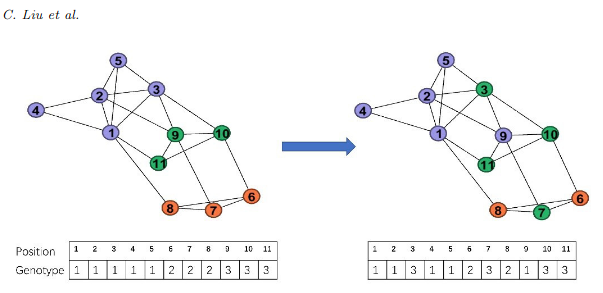
**4.irudia**. Lehenengo funtzioaren adibide bat.


### Bigarren metodoa
Gure probleman komunitate kopurua zehaztuta ematen diguten zerbait da. Beraz, funtzio honek komunitate kopuru desberdinak aztertzen ditu. Funtzioak gure soluzioko $\gamma$ komunitate kopurua hartzen ditu ausaz. Ondoren, $\gamma$ komunitate barruan dauden nodo guztiak komunitate bihurtzen ditu non, komunitate bakoitza nodo bakar batez osatuta egongo den. $\gamma$ parametroak perturbazioaren indarra adierazten digu. Erabaki dugu, Liu, C. et al [2] arabera, honen balioa 1-ekin hasieratzea eta handituz joango gara balioari 1 gehituz iterazio horretan lortzen den optimoa onartze irizpideak betetzen ez baditu. Bestela, $\gamma$ 1ekin hasieratuko da berriz. $\gamma$-k hartu dezakeen balio altuena 0.6 * |s| (soluzioan ditugun komunitate kopurua) izango da komunitate gehiegi ez sortzeko.  

Hurrengo argazkian (ikus 5.irudia), funtzioaren adibide bat daukagu. Zehazki, {9, 10, 11} multzoko nodoak komunitate bat osatzen dute eta nodo bakoitza komunitate berri bat sortzen du.

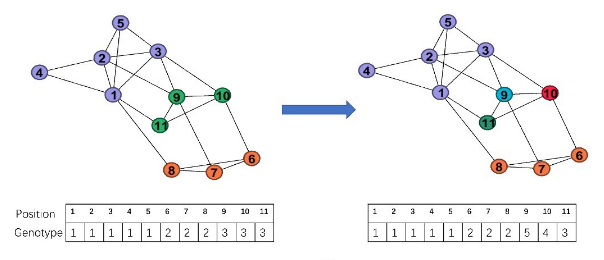
**5.irudia**. Bigarren funtzioaren adibide bat.

### Sasikodea
**Sarrera:**
* $G$ : grafo bat nodo bakoitza idazle bat izanik eta ertzak idazleen arteko elkarlana adieraziz
* $s$ : momentu arte soluziorik onena, non adierazita dago nodo bakoitza ze partizioan dagoen

**Irteera:** $s$: soluzioa perturbatuta

**Algoritmoa:**
>1: Ausaz k zenbaki bat aukeratu 1 eta 2 artean
>
>2: **switch**(k)
>
>3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **case 1:** s ← Mugitu(G(V, E), s)
>
>4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **case 2:** s ← Banatu(G(V, E), γ, s)
>
>5: **end switch**
>
>6: **return** s

### Kodea

In [ ]:
def swapPositions(solution, i, j):
    lag = solution[i]
    solution[i], solution[j] = solution[j], lag
    return solution

def mugitu(G, best_partition, best_solution, beta = 0.3):
    k = int(len(G.nodes())*beta) #perturbatuko diren nodo kopurua
    
    while k >= 0:
        for node in G:
            boundary= False
            auzokideak = list(G[node].keys())
            for a in auzokideak:
                if best_partition[a] != best_partition[node]:
                    boundary = True
                    best_solution = swapPositions(best_solution, best_partition[a], best_partition[node])
                    k -= 1
                    if k <= 0:
                        return best_solution
                    break
    return best_solution


In [ ]:
def banatu(G, best_partition, best_solution, gamma):
    k_max =  max(list(best_partition.values()))
    assert(gamma <= 0.6*k_max)
    
    komunitateak = rm.sample(list(np.unique(best_solution)), gamma)
    lag = copy.deepcopy(best_solution)
    inkr = 1
    
    for sol in best_solution:
        if sol in komunitateak:
            lag[sol] = k_max + inkr
            inkr +=1
    return lag
    

In [ ]:
def pertubatu(G, best_solution, best_partition, gamma):
    k = rm.randint(1,2)
    if k == 1:
        solution = mugitu(G, best_partition, best_solution)
    else:
        solution = banatu(G, best_partition, best_solution, gamma)
    return solution

## Onartzeko irizpidea: Simulated Anneling

Onarpen-irizpideari dagokionez muturreko bi estrategia plantea daitezke: soluzioa beti onartzea eta modu honetan dibertsifikazioa suspertu edo soilik uneko baino hobea denean onartu. Estrategi hauek ez dira oso egokiak, horregaitik soluzioak probabilitate batekin onartuko ditugu. Zehazki, *simulated anneling*-en onarpen irizpidea erabiliko dugu[1]. Honen bidez hasiera batean dibertsifikazio altua izango dugu hasierako tenperatua altua baita, gehiago esploratuz. Ondoren, joango gara esplotatzen tenperatura jaitsi ahala.

*Simulated anneling*-ek iterazioan sortutako $s^*´$ soluzioa onartuko du bere modularitatea momentuko $s^*$-ko baino hobea baldin bada. Bestela, probabilitate batekin onartuko da: $ exp(\frac{modularity(s^*´) − modularity(s^*)}{T})$ non, T tenperatura izeneko parametro bat den. Liu, C. et al [2] arabera, $T_{init}$ = 0.025 x modularity$(s^*)$ izango da modu horretan s* baino %2.5 okerrago den soluzio bat onartuko da 1/e probabilitaterekin. Tenperatura iterazio bakoitzean txikituz joango da *cool* parametro baten bidez. Erabaki da, berriz ere Liu, C. et al [2]  arabera, parametro honen balioa 0.9 izatea eta era geometriko batean tenperatura hoztea modu horretan.

### Sasikodea
**Sarrera:** uneko soluziorik onena s* eta iterazio horretan lortutako soluziorik onena $s^*´$
 
**Irteera:** hurrengo iterazioko s*

**Algoritmoa:**
> 1: **if** Q($s^∗′) ≥ Q(^∗)$ **then**
>
> 2: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^∗ ← s^∗′$
>
> 3: **else**
>
>4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; p ← rand(0, 1)
>
>5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** p ≤ exp (modularity$(s^∗′)$ − modularity$(s^∗$)/T **do**
>
>6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s^∗ ← s^∗′$
>
>7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **end if**
>
>8: **end if**
>
>9: T ← 0.9 × T

### Kodea

In [ ]:
def hasieratu_tenperatu(tenp_degree, best_fitness):
    return tenp_degree * best_fitness

In [ ]:
def simulated_anneling(G, best_solution, best_partition, best_fitness, sol_lag, fit_lag, tenp_degree, cool, T, gamma):    
    gamma_ = 1
    
    if fit_lag > best_fitness:
        best_solution = sol_lag
        best_fitness = fit_lag

    else:
        tenp_aldaketa = fit_lag - best_fitness
        zbk = rm.uniform(0, 1)
        prob = math.exp((tenp_aldaketa/T))

        if zbk < prob: #onartuko dugu
            best_solution = sol_lag
            best_fitness = fit_lag
        else: 
            gamma_ = gamma + 1
            k_max =  max(list(best_partition.values()))
            if gamma <= 0.6*k_max:
                gamma_ -= 1
  
    T *= cool
    gamma = gamma_
    
    return T, gamma, best_solution, best_fitness


## Optimoaren eguneraketa
Onartze irizpidearen bidez iterazio horretan lortutako optimoa onartzea erabakitzen da probabilitate batekin. Hortaz, gerta daiteke lortutako soluzioa uneko optimoa baino hobea ez izatea baina onartze irizpideak onartu izatea *simulated anneling* bidez soluzio txarrak onartu daitezkeelako. Soluzio hori, ona nahiz txarra, hurrengo iterazion erabiliko da uneko optimo bezala baina soluzio guztietatik onena bezala ez da onartuko. Ez da itzultzen den $s_{best}$ izango, bakarrik erabilia izango da hurrengo iterazioan perturbatzeko eta *simulated annelingean* uneko soluzio optimo bezala. Hau kontrolatzeko hurrengoa egiten da:

>  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **if** $Q(s^*)$ > Q($s_{best}$) **then**
>
>  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$s_{best} = s^* $  

## Iterated Local Search

Aurretik aipatuta sasikode inplementatuko dugu orain.



### Kodea


In [ ]:
def ILS(G, best_solution, k, max_evals, tenp_degree=0.00025, cool=0.9):  
    best_partition = dict(zip(G.nodes, best_solution))
    best_fitness,_,_ = modularitatea2OPT(G, best_partition, degree, m)
    print("Hasierako modularitate:" + str(best_fitness))
    best_fitness_ = best_fitness
    best_solution_ = best_solution
    T = hasieratu_tenperatu(tenp_degree, best_fitness)
    gamma = 1
    while max_evals >= 0:
        solution = pertubatu(G, best_solution, best_partition, gamma)
        solution, fitness, max_evals = local_search(G, k, solution, max_evals)
        T, gamma, best_solution, best_fitness = simulated_anneling(G, best_solution, best_partition, best_fitness, solution, fitness, tenp_degree, cool, T, gamma)
        if best_fitness > best_fitness_:
            best_fitness_ = best_fitness
            best_solution_ = best_solution
    print(best_fitness)
    return (best_fitness_, best_solution_, max_evals)

Probatuko dugu gure algoritmoa 10000 ebaluzio kopuru maximo izanda.

In [ ]:
k = 5
start = time.time()
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
initial_sol = from_dict_to_list(G, partizioa)

### Optimizatu barik

In [ ]:
best_fitness, best_solution, evals = ILS(G,initial_sol, k, 10000)
print("Amaierako modularitatea aurre-prozesatutako grafoan: " + str(best_fitness))
best_partition = dict(zip(G.nodes, best_solution))
best_partition1 = kanpokoak_sartu(best_partition, k)
print("Amaierako modularitatea problemaren grafoaren gainean: ", modularitatea2OPT(G, best_partition1, degree, m)[0])

In [ ]:
import cProfile
import re
cProfile.run("ILS(G,initial_sol, k, 10000)")

### Optimizatuta

In [ ]:
best_fitness, best_solution, evals = ILS(G,initial_sol, k, 10000)
print("Amaierako modularitatea aurre-prozesatutako grafoan: " + str(best_fitness))
best_partition = dict(zip(G.nodes, best_solution))
best_partition1 = kanpokoak_sartu(best_partition, k)
print("Amaierako modularitatea problemaren grafoaren gainean: ", modularitatea2OPT(G, best_partition1, degree, m)[0])

In [ ]:
import cProfile
import re
cProfile.run("ILS(G,initial_sol, k, 1000000)")

Jarraian, lortutako soluzioak irudikatuko daude partizio bakoitza kolore batez margotuta dagoelarik. Lehenengo grafoa aurre-prozesatutako grafoa da eta bigarrena sarreran sartutako grafoa.

In [ ]:
#partizioak_irudikatu(G , k , best_partition)

In [ ]:
#partizioak_irudikatu(G_ , k , best_partition1)

Probatuko dugu gure algoritmoa 100000 ebaluzio kopuru maximo izanda.

### Emaitza hauek optimizatuta lortzen dira

In [ ]:
k = 5
partizioa = algoritmo_eraikitzailea(G,k, weight= 'weight')
initial_sol = from_dict_to_list(G, partizioa)
best_fitness, best_solution, evals = ILS(G,initial_sol, k, 1000000)
print("Amaierako modularitatea aurre-prozesatutako grafoan: " + str(best_fitness))
best_partition = dict(zip(G.nodes, best_solution))
best_partition1 = kanpokoak_sartu(best_partition, k)
print("Amaierako modularitatea problemaren grafoaren gainean: ", modularitatea2OPT(G, best_partition1, degree, m)[0])

Jarraian, lortutako soluzioak irudikatuko daude partizio bakoitza kolore batez margotuta dagoelarik. Lehenengo grafoa aurre-prozesatutako grafoa da eta bigarrena sarreran sartutako grafoa.

In [ ]:
#partizioak_irudikatu(G, k , best_partition)

In [ ]:
#partizioak_irudikatu(G_ , k , best_partition1)

Lortzen ditugun emaitzak Random Search-ekin lortu direnak baino hobeak dira beraz, algoritmo onargarria da. Hasierako soluzioa hobetu egiten da ebaluazio maximo kopurua handitu ahala. ILS aukeratu dugu beste algoritmoen gainetik aukera asko eskaitzen dizkigulako. Alde batetik, soluzio perturbatzeak optimo lokaletan ez ataskatzeko aukera ematen digu. Beste alde batetik, *simulated anneling* erabiliz onartze irizpide moduan esplotazioa eta esplotazioa kontrolatzeko aukera ematen digu.  

Egia da, ILS algortimoa *simulated anneling* ez bezala algoritmo jale bat dela ez baitu ingurunetik bat ausaz hartzen baizik eta irizpide bat jarraitzen du. Honek garestitzen digu algoritmoa baina *best first* irizpidearen bidez lortzen dugu merketzea. Hala ere, soluzio optimora hurbiltzen denean ebaluazioa asko behar ditu. Nahiz eta alde txarrak izan parametro gutxi behar ditu eta horietako askorentzat balio on bat zein den aurkitu dugu Liu,c et al[2] esker.


## Erreferentziak
1. Calvo, B., Cebeiro, J., Mori, U., "Bilaketa heuristikoak. Teoria eta Adbideak R Lengoaian", Euskal Herriko Unibertsitatea Argitalpen Zerbitzua (2017)
2. Liu, C., Kang, Q., Kong, H., Li, W., & Kang, Y,  "An iterated local search algorithm for community detection in complex networks", International Journal of Modern Physics B, 34(04), 2050013. (2020)

# EDA
Soluzio hobetzeko probekin jarraiuz EDA motako algoritmo bat inplementatu dugu, gure kasuan UMDA aldaera erabili dugu. EDA motako algoritmoak populazioetan oinarritzen dira, populazioko indibiduo bakoitza soluzio (partizio) posible bat izanik. Populazioan indibiduoak aldatzen joango dira, probabilitate matrizea erabiliz. Probabilitate matrizeak n soluzio onenen gen bakoitzaren balioaren probabilitatea jasotzen du; ondoren, probabilitate horiekin, soluzio berriak lagintzen dira. 6. irudian ikus daiteke nola funtzionatzen duen.
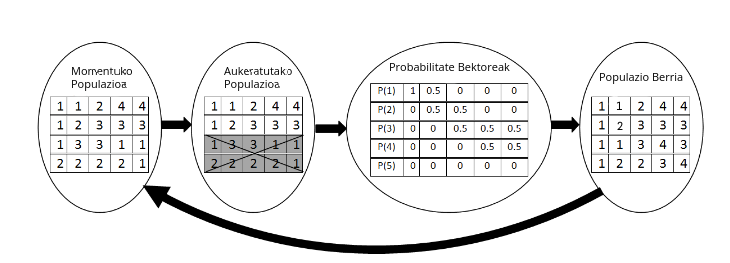
**6.irudia** UMDA aldaeraren funtzionamendua.  
Zehazki gure UMDA algoritmoak ondorengoa egingo du:
1. Populazioa hasieratu ausazko soluzio batzuk sortuz
2. Aukeratu (tournament selection erabiliz) n soluzio populaziotik
3. Aukeratutako soluzioekin probabilitate matrizea sortu 
4. Probabilitate bektorea erabiliz soluzio berriak lagindu
5. Soluzio berriak mutatu probabilitate batekin
6. Soluzio berriak populaziora sartu, populazioko indibiduo txarrenak (modularitate baxuena dutenak) ezabatuz.
7. Gelditze irizpide betetzen bada amaitu eta soluzio hoberena itzuli, bestela 2 pausura bueltatu.



## Tournament Selection

Tournament Selection erabilitako aukeratze irizpidea da. Aukeraketa mota honetan, helburu-funtzioak emandako balioaren arabera ordenatzen dira soluzioak. Ordenatu ondoren, aukeratze probabilitate bat ematen zaio elementu bakoitzari. Horrela, lehenengoa aukeratzeko Pt probabilitatea egongo da, bigarrena aukeratzeko $(1-Pt)* Pt$, hirugarrena aukeratzeko $(1-Pt)^2 * Pt$ etab. Hau n aldiz egingo da, kontuan izanik behin soluzio bat aukera denean, ezingo dela berriro ere aukeratu. Modu honetara n elementu ezberdin aukeratu nahi dira probabilitate bektorea sortzeko.  

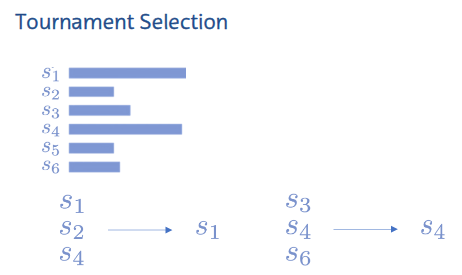


**7. irudia** Tournament Selection iripidea. [2]

## Probabilitate Bektoreak

Probabilitate bektore bat egongo da kluster bakoitzeko. Hauetako dimentsio bakoitzak nodo zehatz bat kluster horretan egoteko probabilitatea jasotzen ditu. Probabilitate hau kalkulatzeko aukeratutako soluzioen nodo bakoitzean dauden balioak aztertzen dira; berdinak diren balioak kontatuz eta kopuru osoarekin zatituz, probabilitateak lortzen dira. 



## Mutatu

Nahiz eta EDA algoritmoek orokorrean ez dituzteten mutazioak erabiltzen gure algoritmoan erabiltzen dira. Hauekin, bilaketa espazioa esploratzeko ahalmena handitzen da. Mutazioa, soluzio berri bat sortzen denean Pm probabilitatearekin emango da. Ematen denean, ausaz gen bat aukeratu eta bere balioari ausazko balio berri bat emango zaio. 

## Gelditze Irizpidea

Gure algoritmoak amaitzeko bi irizpide erabiltzen ditu: Alde batetik, iterazio kopuru maximo bat dugu: `iterkop`. Kopuru horretara iritsiz gero algoritmoa gelditu egingo da. Beste aldetik, `g` iterazioetan zehar gure emaitza hoberena ez bada aldatu ere amaitu egingo da ejekuzioa.


## Sasikodea
***Sarrera***

G: Sarrera Grafoa

k: Kluster kopurua

Poplen: Populazioaren Tamaina

Pmut: Mutatzeko probabilitatea

g: Soluzioa hoberena berdin mantendu daitekeen iterazio kopuru maximoa

iterkop: Iterazio kopuru maximoa

***Irteera***
Azken iterazioko populazioaren soluzio hoberena

***Algoritmoa***
> 1: populazioa = hasieratuPopulazioa(G,k,Poplen)
>
> 2: **while** **not** gelditzeBaldintza(g,iterkop) **do**
>
> 3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; populazioaAuk = aukeratuPopulazioan(populazioa)
>
> 4: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; probabilitateBektorea = sortuProbabilitateBektorea(populazioaAuk)
>
> 5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; soluzioBerriak = lagindu(probabilitateBektorea)
>
> 6: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; soluzioBerriak = mutatu(soluzioBerriak,Pmut)
>
> 7: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; populazioa = berriakSartu(populazioa,soluzioBerriak)
>
> 8: ***end while***
>
> 9: ***return*** populaziokoHoberena(populazioa)

## Erreferentziak

1. M. G. Parsa, N. Mozayani, A. Esmaeili, "An EDA-based community detection in complex networks," 7'th International Symposium on Telecommunications (IST'2014), 2014, pp. 476-480
2. Ceberio, J., "5. Evolutionary Computation", e-gela gardenkiak

## Kodea

In [ ]:
import cProfile

def EDA(G,k,poplen,Pprob,Pmut,offSpring,g,iterkop,maxEvals):
    populazioa = [hasieratuP(G,k) for i in range(poplen)]
    iterazio = 0
    hoberena = -1
    ezAldatu = 0
    AUKERAK = poplen//5
    TOURNAMENT = poplen//2
    modularitatea = [modularitatea2OPT(G,x,degree,m)[0] for x in populazioa]
    evals = len(populazioa)
    populazioa = sorted(populazioa, key=lambda x: modularitatea[populazioa.index(x)], reverse=True)
    modularitatea = sorted(modularitatea, reverse=True)
    probVec = probabilitateVecHasiera(G,k,populazioa)
    while iterazio < iterkop and ezAldatu < g and evals < maxEvals:
        popOpt = tournament(populazioa,AUKERAK,TOURNAMENT) 
        probVec = probabilitateVec(G,k,popOpt,probVec,Pprob)
        if iterazio % 10 == 0:
            print("ITERAZIOA: " + str(iterazio))
            print("EGINDAKO EVALS KOPURUA:" + str(evals))
            print("POPULAZIOAREN BALIO HOBERENA: "+ str(modularitatea2OPT(G,populazioa[0],degree,m)[0])) 
        lagPop, lagMod = lagindu(G,k,probVec,offSpring,int(poplen-AUKERAK))
        populazioa[AUKERAK:poplen] = lagPop
        modularitatea[AUKERAK:poplen] = lagMod
        evals += offSpring
        for i in range(AUKERAK,poplen):
            mutatu = rm.random()
            if mutatu >= Pmut:
                populazioa[i] = mutazioa(G,k,populazioa[i])
                modularitatea[i] = modularitatea2OPT(G,populazioa[i],degree,m)[0]
                evals += 1
        iterazio += 1
        hoberena = copy.deepcopy(populazioa[0])
        populazioa = sorted(populazioa, key=lambda x: modularitatea[populazioa.index(x)], reverse=True)
        modularitatea = sorted(modularitatea, reverse=True)
        if hoberena == populazioa[0]:
            ezAldatu+=1
        else:
            ezAldatu = 0
    return populazioa[0]

def probabilitateVec(G,k,popu, probZahar,Pprob):
    dicHuts = {}
    for node in G:
        dicHuts[node]=0.0
    probMat = [copy.deepcopy(dicHuts) for j in range(k)]
    for i in range(len(popu)):
        for node in G:
            probMat[popu[i][node]][node] += 1.0/len(popu)
    for i in range(len(probZahar)):
        for node in G:
            probMat[i][node] = (1.0-Pprob)*probZahar[i][node] + Pprob*probMat[i][node]
    return probMat

def mutazioa(G,k,partizio):
    aukeratutakoa = rm.choice([node for node in G])
    aldatu = rm.randrange(k)
    partizio[aukeratutakoa] = aldatu
    return partizio
    
def hasieratuP(G, k):
    partizioaAusaz = {}
    for node in G:
        partizioaAusaz[node]=rm.randrange(k)
    return partizioaAusaz

def tournament(popu,luzera,auklen):
    aukerak = rm.sample(range(len(popu)),auklen)
    aukerak = sorted(aukerak, reverse=False)
    aukerak = aukerak[0:luzera]
    emaitza = [popu[i] for i in aukerak]
    return emaitza

def probabilitateVecHasiera(G,k,popu):
    dicHuts = {}
    for node in G:
        dicHuts[node]=0.0
    probMat = [copy.deepcopy(dicHuts) for j in range(k)]
    for i in range(len(popu)):
        for node in G:
            probMat[popu[i][node]][node] += 1.0/len(popu)
    return probMat

def lagindu(G,k,probVec,offSpring,emaitzLuz):
    dicHuts = {}
    for node in G:
        dicHuts[node]=0.0
    bek = [copy.deepcopy(dicHuts) for i in range(offSpring)]
    for i in range(offSpring):
        for node in G:
            aukera = rm.random()
            zenbat = 0
            for j in range(k):
                zenbat+=probVec[j][node]
                if zenbat >= aukera:
                    bek[i][node] = j
                    break
    modularitatea2 = [modularitatea2OPT(G,x,degree,m)[0] for x in bek]
    bek = sorted(bek, key=lambda x: modularitatea2[bek.index(x)], reverse=True)
    modularitatea2 = sorted(modularitatea2, reverse=True)
    return bek[0:emaitzLuz] , modularitatea2[0:emaitzLuz]



#aukera = EDA(G,200,1000,1000) 0.011657931788842184
cProfile.run("EDA(G,5,200,0.8,0.95,200,100,1000,1000000)")

## Ondorioak
Nahiz eta gure algoritmoak oinarri-lerroa baina hobeto funtzionatu ez ditu guk esperotako emaitzak eman. Hala ere, hurrengo fasean jarraituko dugu honekin probak egiten bere errendimendua hobetzeko ideiearekin.